# Perform historical solar disaggregation
This notebook perform the historical solar disaggregation at the individual house level and plot the results.


In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
# import ipy_autoreload
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csss
import datetime as dt
import pickle as pk
from imp import reload
import copy
from time import time as t_clock
from copy import deepcopy
import seaborn as sns
from csss.SolarDisagg import createTempInput, createSolarDisaggIndvInputs
from csss.utilities import Setup_load as SetUp_load
import math
import pprint
from Custom_Functions.error_functions import cv_pos,rmse_pos

### Load the data

In [2]:
Setup_load = deepcopy(SetUp_load())
Setup_load.QueryOrLoad()#(start_date = '01-01-2015', end_date = '01-10-2015')
load_data, load_data_2, weather, grouped_data, ids, solar_ids, homeids  = Setup_load.load_setup()
load_data_2['temperature'] = weather['temperature']

reading 61047030 values from csv took 7.69 seconds
There are 167 homes with complete data
105 homes solar
62 homes with no solar


### Cleaning the data

In [3]:
## Remove those solar houses that have generation = 0 for continous N_obs.
N_obs_day = 96 # number of observations in one day.
N_obs = 3*N_obs_day
remove = []
for i in solar_ids['solar']:
    df = grouped_data.get_group(i)
    roll_mean = df.gen.rolling(N_obs).mean()
    if np.nansum(roll_mean < 0.001) > 0:
        remove.append(i)
len(remove)

## Update the data accordingly
ids = list(set(ids) - set(remove))
load_data = load_data[~load_data['dataid'].isin(remove)]
load_data_2.swaplevel(axis = 1).drop(remove,axis = 1, inplace = True)
solar_ids['solar'] = list(set(solar_ids['solar']) - set(remove))
solar_ids['nosolar'] = list(set(solar_ids['nosolar']) - set(remove))
grouped_data = load_data.groupby("dataid")

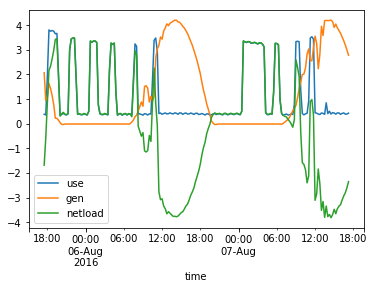

In [4]:
## Do a quick plot of load data
df = deepcopy(grouped_data.get_group(solar_ids['solar'][0]))
np.random.seed(9)
start = np.random.choice(range(len(df)))
df.iloc[start:start+2*96,1:].plot()
plt.show()

### Data preparation

In [6]:
df = deepcopy(load_data_2)
Nproxies = 2
Ntunesys = 2
 ## Choose homes and proxies
proxy_ids = list(np.random.choice(solar_ids['solar'],Nproxies, replace = False))
tune_ids = list(np.random.choice(list(set(solar_ids['solar'])-set(proxy_ids)),Ntunesys,replace = False))
if not tune_ids:
    tune_ids = proxy_ids
home_ids = list(np.random.choice(list(set(ids)-set(tune_ids)-set(proxy_ids)),20,replace = False)) + tune_ids

# pd.to_datetime('01-09-2019')
n_days = 30 # number of days to analyse
resolution_minutes = (df.index[1]-df.index[0]).seconds/60 # determine the resolution of the data
time_index = [df.index[0],df.index[min(len(df.index)-1,int(24*60/resolution_minutes*n_days))]] # beginiing and end datetime of the window to analyse
index_time = df.index[(df.index >= time_index[0]) & (df.index <= time_index[1])] # index useful to plot later

 ## Creating the data for ingestion in Solar Disagg
data = createSolarDisaggIndvInputs(df, home_ids, solar_proxy_ids= proxy_ids, time_index = time_index)
# pprint.pprint(data, indent=1)

### Solar disaggregation

In [7]:
 ## Initial model
reload(csss.SolarDisagg)
sdmod0 = deepcopy(csss.SolarDisagg.SolarDisagg_IndvHome(**data))
sdmod0.constructSolve(solver = None) # if solver = None, it uses the default one
 ## Adding tuning system generation
for key in tune_ids:
    sdmod0.addTrueValue(-df['gen'][key].loc[index_time], str(key))
 ## update the alpha weights and perform the disaggregation
sdmod0.fitTuneModels(list(map(str,tune_ids)))
sdmod0.tuneAlphas()
sdmod0.constructSolve(solver = None)

2.8146846375834107

### Plot the results

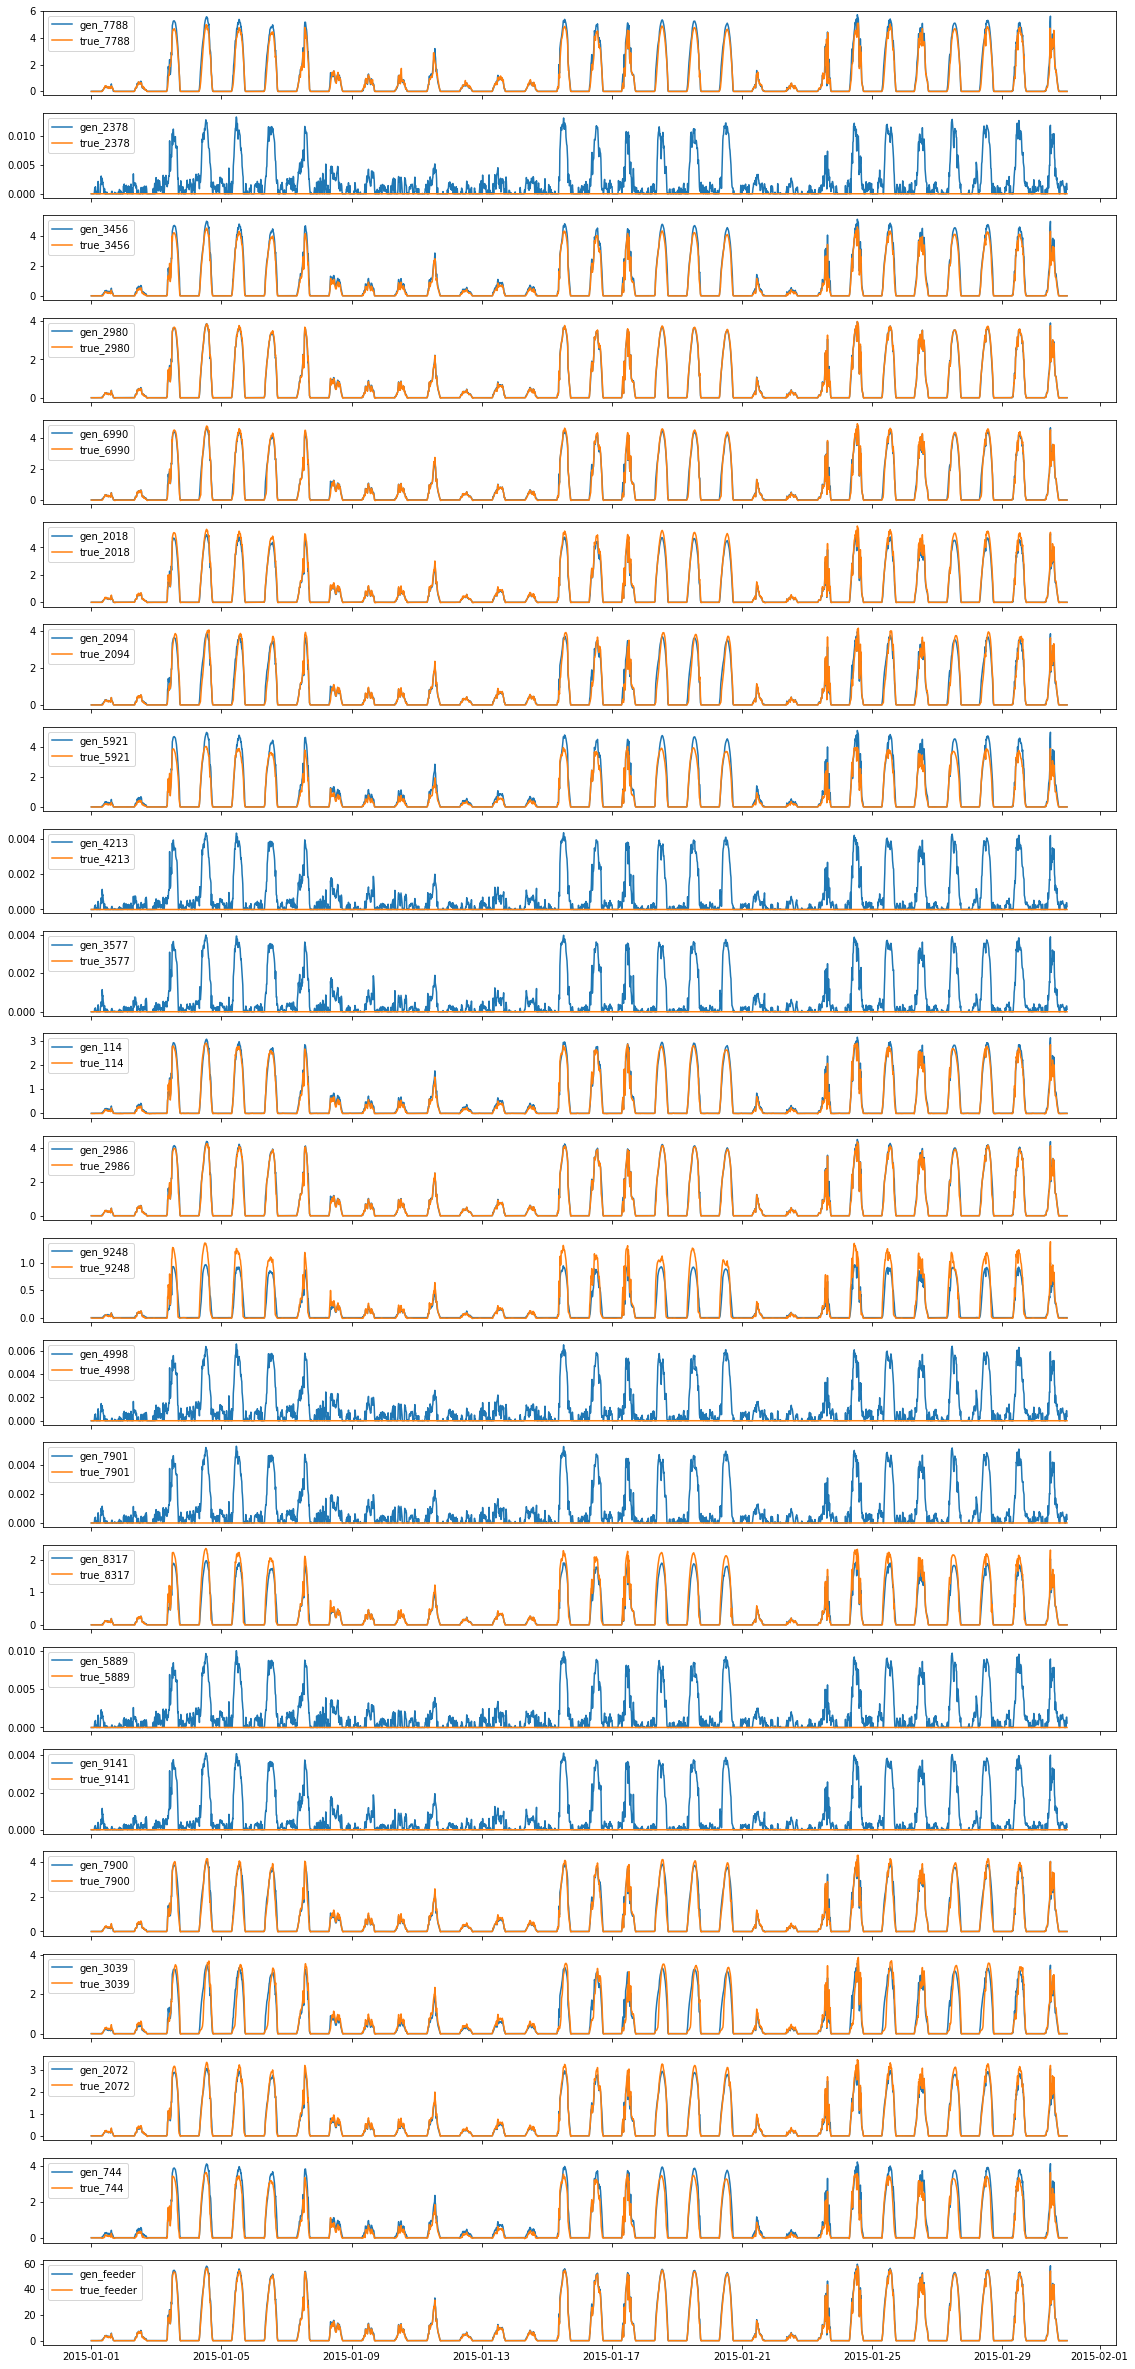

In [9]:
n_homes = len(home_ids)
n_pts = len(index_time) # number of points to plot
fig, ax = plt.subplots(nrows= n_homes+1, ncols=1, sharex=True, figsize=(16,1.5*n_homes)) # n_pts/96*1.5
for i in range(n_homes):
    idd = str(home_ids[i])
    ax[i].plot(index_time,-sdmod0.models[idd]['source'].value[0:n_pts], label = 'gen_'+idd)
    ax[i].plot(index_time,df['gen'][int(idd)].loc[index_time].values[:n_pts], label = 'true_'+idd)
    ax[i].legend()
## add Feeder Level generation plot
ax[i+1].plot(index_time,np.sum([-sdmod0.models[str(idd)]['source'].value[0:n_pts] for idd in home_ids], axis = 0), label = 'gen_'+'feeder')
ax[i+1].plot(index_time,np.sum([df['gen'][int(idd)].loc[index_time].values[:n_pts] for idd in home_ids], axis = 0), label = 'true_'+'feeder')
ax[i+1].legend()
plt.tight_layout()
plt.show()

In [55]:
## Calculate the error metric
metrics = ['cv_pos','rmse_pos'] ## _pos refer to the fact that the performance metrics are calculated when the actual power (or the predicted power in case of non solar houses) is greater than 5% of its average.
errors = pd.DataFrame(index = home_ids, columns = metrics)
for idd in home_ids:
    errors.loc[idd] = cv_pos(np.array(-sdmod0.models[str(idd)]['source'].value).squeeze(),df['gen'][int(idd)].loc[index_time].values),rmse_pos(np.array(-sdmod0.models[str(idd)]['source'].value).squeeze(),df['gen'][int(idd)].loc[index_time].values)
    

In [56]:
errors

,cv_pos,rmse_pos
3831,NaN,0.000123443
9922,NaN,0.00338837
8236,0.639613,1.12563
9484,NaN,0.00263098
3538,0.538461,0.703539
6498,NaN,0.00135767
7850,0.383191,0.583397
545,0.113836,0.100867
4473,NaN,0.000129917
6990,0.368017,0.669918
